[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZSUwS1kfvF7svFaovb3W")
project = rf.workspace("image-annotation-uwwcl").project("student-attention-detection-unv2i")
version = project.version(1)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Student-attention-detection-1 in yolov12:: 100%|██████████| 2964/2964 [00:00<00:00, 5707.10it/s]


In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Thu Mar 13 11:34:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 74.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [6]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [7]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 3
names: ['Attentive', 'Distracted', 'Teacher']

roboflow:
  workspace: image-annotation-uwwcl
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [10]:
!pip install ultralytics

In [11]:
from ultralytics import YOLO

# تحميل النموذج
model = YOLO('yolov12m.yaml')

# تدريب النموذج مع ضبط الهايبر بارامترز
results = model.train(
    data=f'{dataset.location}/data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,  # عدد الصور لكل batch
    lr0=0.01,  # معدل التعلم الأساسي
    lrf=0.1,  # انخفاض معدل التعلم مع التقدم
    momentum=0.937,  # الثبات أثناء التدريب
    weight_decay=0.0005,  # تجنب الإفراط في التكيف
    optimizer="AdamW",  # استخدام AdamW لتحسين الأداء
    project="/content/drive/MyDrive",
    name="YOLOv12m_optimized_training"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.90 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12m.yaml, data=/content/Student-attention-detection-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive, name=YOLOv12m_optimized_training6, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, re

100%|██████████| 755k/755k [00:00<00:00, 120MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2, 1, 2]         
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    147968  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2, 1, 4]        
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2664960  ultralytics.nn.modules.block.A2C2f           [512, 512, 2, True, 4]        
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 335MB/s]


AMP: checks passed ✅


train: Scanning /content/Student-attention-detection-1/train/labels... 1125 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1125/1125 [00:01<00:00, 724.60it/s]


train: New cache created: /content/Student-attention-detection-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Student-attention-detection-1/valid/labels... 202 images, 0 backgrounds, 0 corrupt: 100%|██████████| 202/202 [00:00<00:00, 485.83it/s]

val: New cache created: /content/Student-attention-detection-1/valid/labels.cache


Plotting labels to /content/drive/MyDrive/YOLOv12m_optimized_training6/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 131 weight(decay=0.0), 138 weight(decay=0.0005), 137 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/YOLOv12m_optimized_training6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      12.7G      3.807      3.638      3.542         67        640: 100%|██████████| 71/71 [01:07<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]

                   all        202       1998    0.00158       0.03   0.000981   0.000373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.4G      3.124      2.983      2.715         32        640: 100%|██████████| 71/71 [01:06<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        202       1998    0.00158       0.03   0.000981   0.000373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.2G      2.845      2.719      2.437         93        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        202       1998      0.421     0.0948     0.0302     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.3G       2.71      2.563      2.298         77        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]

                   all        202       1998     0.0743     0.0687     0.0282    0.00927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.2G      2.493      2.332      2.195         46        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

                   all        202       1998      0.139      0.121     0.0707     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.3G      2.398      2.248      2.112         31        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

                   all        202       1998      0.482      0.157     0.0968     0.0375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      12.3G       2.38      2.149      2.064         39        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]

                   all        202       1998      0.435      0.114     0.0829     0.0285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      12.3G      2.315      2.144      2.009         48        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        202       1998      0.167       0.11     0.0797     0.0272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      12.2G      2.181      1.983      1.917         28        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        202       1998       0.57      0.258      0.186      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      12.3G      2.172       1.94       1.91         33        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        202       1998      0.568      0.305      0.219     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      12.3G      2.131      1.896      1.911        141        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]

                   all        202       1998      0.222       0.28       0.21      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      12.4G      2.082      1.832      1.875         29        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998      0.571      0.289      0.219     0.0953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      12.3G      2.111      1.828      1.863         49        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        202       1998      0.536      0.305      0.204     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.2G      2.045      1.789      1.824         71        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

                   all        202       1998      0.572      0.308      0.227     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.6G      1.976      1.697       1.77         77        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        202       1998       0.61      0.285      0.251      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      12.3G      1.953      1.637      1.768         90        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        202       1998      0.618      0.285      0.246      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      12.7G      1.979      1.682      1.763         62        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        202       1998      0.618      0.315      0.259      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.4G      1.939      1.619      1.763         35        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

                   all        202       1998      0.646      0.289      0.268      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      12.3G      1.899      1.611      1.742         46        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        202       1998       0.63      0.303      0.264      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.4G      1.858       1.55      1.725         39        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        202       1998      0.656      0.325       0.31      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      12.2G      1.883      1.561      1.711         43        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998      0.639      0.322      0.309      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      12.5G      1.815      1.522       1.69         37        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        202       1998      0.632        0.3      0.303      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      12.4G      1.848      1.523      1.694         38        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.654      0.336      0.328      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.2G      1.816      1.509       1.68        145        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        202       1998      0.638      0.375      0.346      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.3G      1.841      1.474      1.655         29        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        202       1998      0.678      0.375      0.349      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      12.3G      1.818      1.476       1.66        122        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        202       1998      0.693      0.348       0.35      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      12.4G      1.805      1.465      1.649         86        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        202       1998      0.665      0.361      0.349      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      12.3G      1.785      1.428      1.663         39        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        202       1998      0.677      0.339      0.335      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      12.2G      1.756      1.408      1.631         62        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        202       1998      0.745      0.326      0.374      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      12.3G      1.752      1.385        1.6         51        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        202       1998      0.677      0.351      0.347      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      12.7G      1.711      1.359      1.593         52        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        202       1998       0.69       0.34      0.352      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      12.5G      1.724        1.4      1.597         52        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998      0.682      0.366       0.37      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      12.2G      1.705      1.371      1.603         55        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.654      0.398      0.367      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      12.3G      1.714      1.349      1.597         36        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998        0.7       0.37      0.364       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      12.7G      1.741      1.386      1.623         41        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        202       1998      0.691      0.376      0.378      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.4G      1.661      1.301      1.574         62        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        202       1998      0.711      0.358      0.388      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      12.3G      1.717      1.337      1.592         49        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998       0.71      0.365      0.406      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.4G      1.662      1.295      1.567         49        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998      0.682      0.371      0.371      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      12.2G      1.672      1.291      1.559         52        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.676      0.399      0.393      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.4G      1.674      1.297      1.548         34        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        202       1998      0.683      0.414      0.405       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      12.3G      1.656      1.303      1.546         28        640: 100%|██████████| 71/71 [01:04<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        202       1998      0.702      0.411       0.41      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      12.4G      1.654      1.277      1.555         53        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        202       1998      0.693       0.41        0.5      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      12.6G      1.643      1.288      1.538        104        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998      0.702      0.397      0.399      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      12.5G      1.623      1.266      1.517         24        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998      0.717      0.421      0.433      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      12.2G      1.628      1.251      1.542         42        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        202       1998      0.708        0.4      0.413      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      12.4G       1.63      1.228      1.512         44        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        202       1998      0.691      0.393      0.411       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      12.2G      1.568      1.223      1.504         35        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        202       1998      0.721      0.397      0.416      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      12.5G      1.624      1.223      1.511         41        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.733      0.399      0.414      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      12.4G      1.584      1.207      1.495         53        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998      0.725      0.444       0.46      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      12.3G      1.564      1.189      1.489         50        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.699      0.426      0.417      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      12.4G      1.584      1.202      1.495         25        640: 100%|██████████| 71/71 [01:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        202       1998      0.726      0.422      0.439      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      12.3G      1.565      1.162      1.478         60        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

                   all        202       1998      0.712      0.421      0.417      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      12.4G      1.556      1.163      1.471        201        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.744      0.418      0.451      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      12.5G      1.582       1.17      1.471         50        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.744      0.397      0.446      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.4G      1.536      1.137      1.431         33        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

                   all        202       1998      0.723      0.421      0.432      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      12.3G      1.531      1.128       1.45         71        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        202       1998      0.727      0.433      0.463      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      12.4G      1.559      1.154      1.472         62        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        202       1998      0.401      0.443      0.457      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      12.4G      1.558      1.165      1.463         62        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        202       1998      0.716      0.422      0.445      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      12.2G      1.556      1.158      1.472         50        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998      0.737      0.438      0.444      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      12.3G      1.552      1.142      1.453         67        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998      0.395      0.439      0.444      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      12.3G      1.547      1.127      1.441         53        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        202       1998      0.727       0.44      0.468      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      12.3G      1.489       1.08      1.421        127        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        202       1998      0.723      0.461      0.473      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      12.4G      1.502      1.087      1.421         62        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        202       1998      0.745      0.424      0.458      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      12.2G      1.523      1.114      1.437        156        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.748      0.434      0.455      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      12.3G      1.508      1.097      1.419         24        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.744      0.438      0.454       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      12.8G      1.494       1.09      1.425        113        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998       0.41       0.42      0.474      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      12.2G      1.478      1.069      1.397         26        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        202       1998      0.353      0.582      0.487      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      12.3G      1.521      1.102      1.425        127        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        202       1998      0.735      0.444      0.463      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      12.3G      1.477      1.073       1.41         35        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        202       1998      0.396      0.467       0.46      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      12.2G      1.482      1.071      1.414         16        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        202       1998      0.408      0.444      0.474      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      12.3G       1.47      1.084      1.405         24        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.736       0.45       0.48      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      12.4G      1.493      1.091      1.415         43        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.374      0.492      0.476      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      12.2G      1.465      1.051      1.415         51        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        202       1998      0.368      0.501      0.478      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      12.4G      1.454      1.051      1.372         34        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

                   all        202       1998      0.424      0.452      0.473       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      12.7G      1.471      1.071      1.401        108        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        202       1998      0.754      0.451      0.486      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      12.3G       1.45      1.048      1.397         44        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        202       1998      0.747      0.435      0.486      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      12.4G      1.446      1.039      1.395         49        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        202       1998      0.746      0.452      0.494      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      12.3G      1.442      1.031      1.381         74        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.413      0.457      0.498      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      12.3G      1.439      1.038      1.385         24        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        202       1998      0.415      0.459      0.488      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      12.4G      1.427      1.027      1.398        111        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        202       1998      0.751      0.444        0.5      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      12.2G      1.429      1.013      1.378         58        640: 100%|██████████| 71/71 [01:05<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        202       1998      0.496      0.505      0.519       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      12.3G      1.419      1.001      1.377         46        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        202       1998      0.747      0.452      0.497       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      12.3G      1.388     0.9862      1.358         42        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        202       1998      0.758       0.44      0.498      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      12.3G      1.401     0.9833      1.352         40        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        202       1998      0.767      0.445      0.519      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      12.2G      1.407     0.9937      1.362         56        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        202       1998      0.428      0.566       0.49      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      12.5G      1.395     0.9895      1.358         67        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        202       1998       0.76      0.464      0.495      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      12.2G       1.41     0.9882      1.369        134        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        202       1998      0.755       0.46      0.495       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      12.4G      1.384     0.9925      1.351         47        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998       0.43      0.622      0.517      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      12.2G      1.395     0.9804      1.344         62        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]

                   all        202       1998      0.426      0.456      0.501      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      12.2G      1.369     0.9688      1.355        111        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        202       1998      0.417      0.458      0.512      0.301


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      12.4G      1.351     0.9316      1.376         22        640: 100%|██████████| 71/71 [01:04<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        202       1998      0.766      0.455      0.497      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      12.4G      1.338     0.9134      1.363         16        640: 100%|██████████| 71/71 [01:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.762      0.455      0.516      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      12.3G      1.341     0.9018       1.36         25        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]

                   all        202       1998      0.771      0.451      0.524      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      12.4G       1.33     0.9007      1.361         24        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        202       1998      0.432      0.469      0.503      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      12.4G      1.309     0.8914       1.35         13        640: 100%|██████████| 71/71 [01:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        202       1998      0.439      0.465      0.519      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      12.4G      1.305       0.87      1.334         30        640: 100%|██████████| 71/71 [01:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

                   all        202       1998      0.389      0.504      0.512      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      12.2G      1.288     0.8597      1.343         40        640: 100%|██████████| 71/71 [01:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        202       1998      0.448       0.45      0.518      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      12.4G      1.309     0.8752      1.344         31        640: 100%|██████████| 71/71 [01:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        202       1998      0.447      0.454      0.511      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      12.4G      1.295     0.8692      1.336         34        640: 100%|██████████| 71/71 [01:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        202       1998       0.51      0.567      0.525      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      12.4G      1.289     0.8593      1.337         14        640: 100%|██████████| 71/71 [01:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

                   all        202       1998      0.389      0.545       0.52      0.303



100 epochs completed in 1.958 hours.
Optimizer stripped from /content/drive/MyDrive/YOLOv12m_optimized_training6/weights/last.pt, 39.7MB
Optimizer stripped from /content/drive/MyDrive/YOLOv12m_optimized_training6/weights/best.pt, 39.7MB

Validating /content/drive/MyDrive/YOLOv12m_optimized_training6/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 402 layers, 19,578,841 parameters, 0 gradients, 59.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


                   all        202       1998      0.509      0.567      0.525      0.303
             Attentive         90        428      0.473      0.675      0.607      0.329
            Distracted        200       1565      0.723      0.826      0.851      0.523
               Teacher          5          5      0.331        0.2      0.117     0.0562
Speed: 0.3ms preprocess, 16.4ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to /content/drive/MyDrive/YOLOv12m_optimized_training6


## Evaluate fine-tuned YOLOv12 model

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

ls: cannot access '/content/runs/detect/train/': No such file or directory


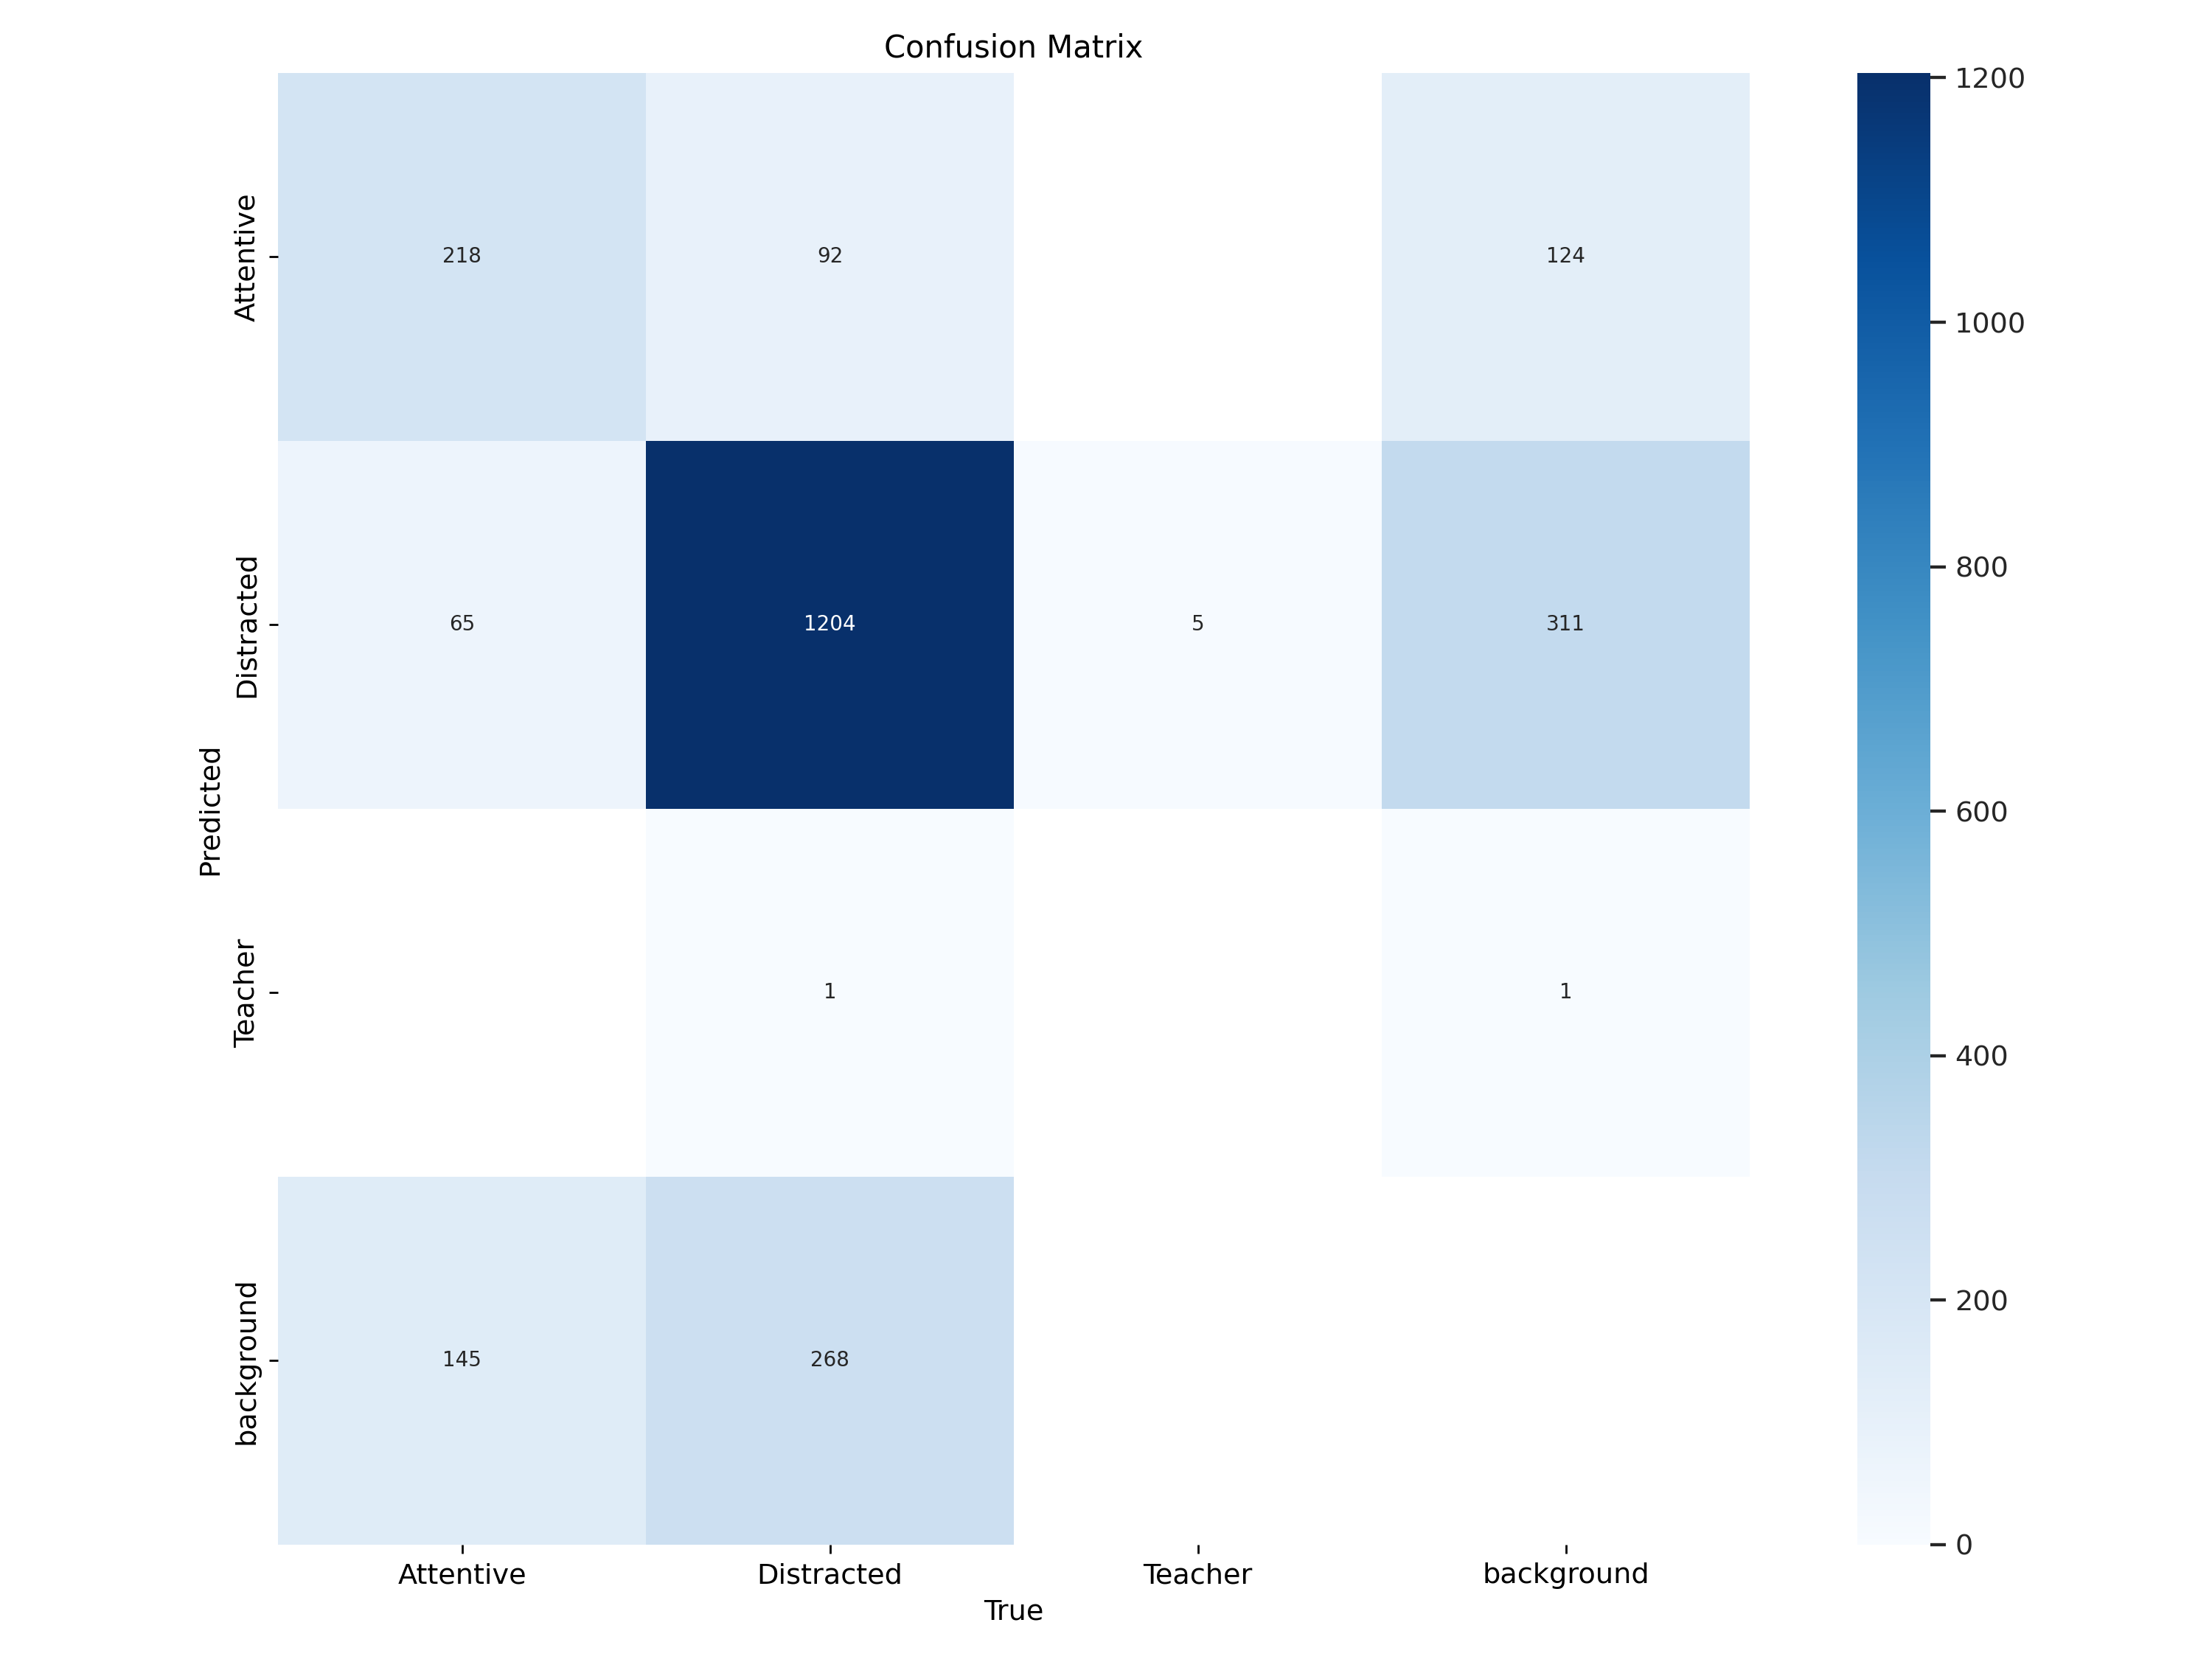

In [17]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/YOLOv12m_optimized_training6/confusion_matrix.png', width=1000)

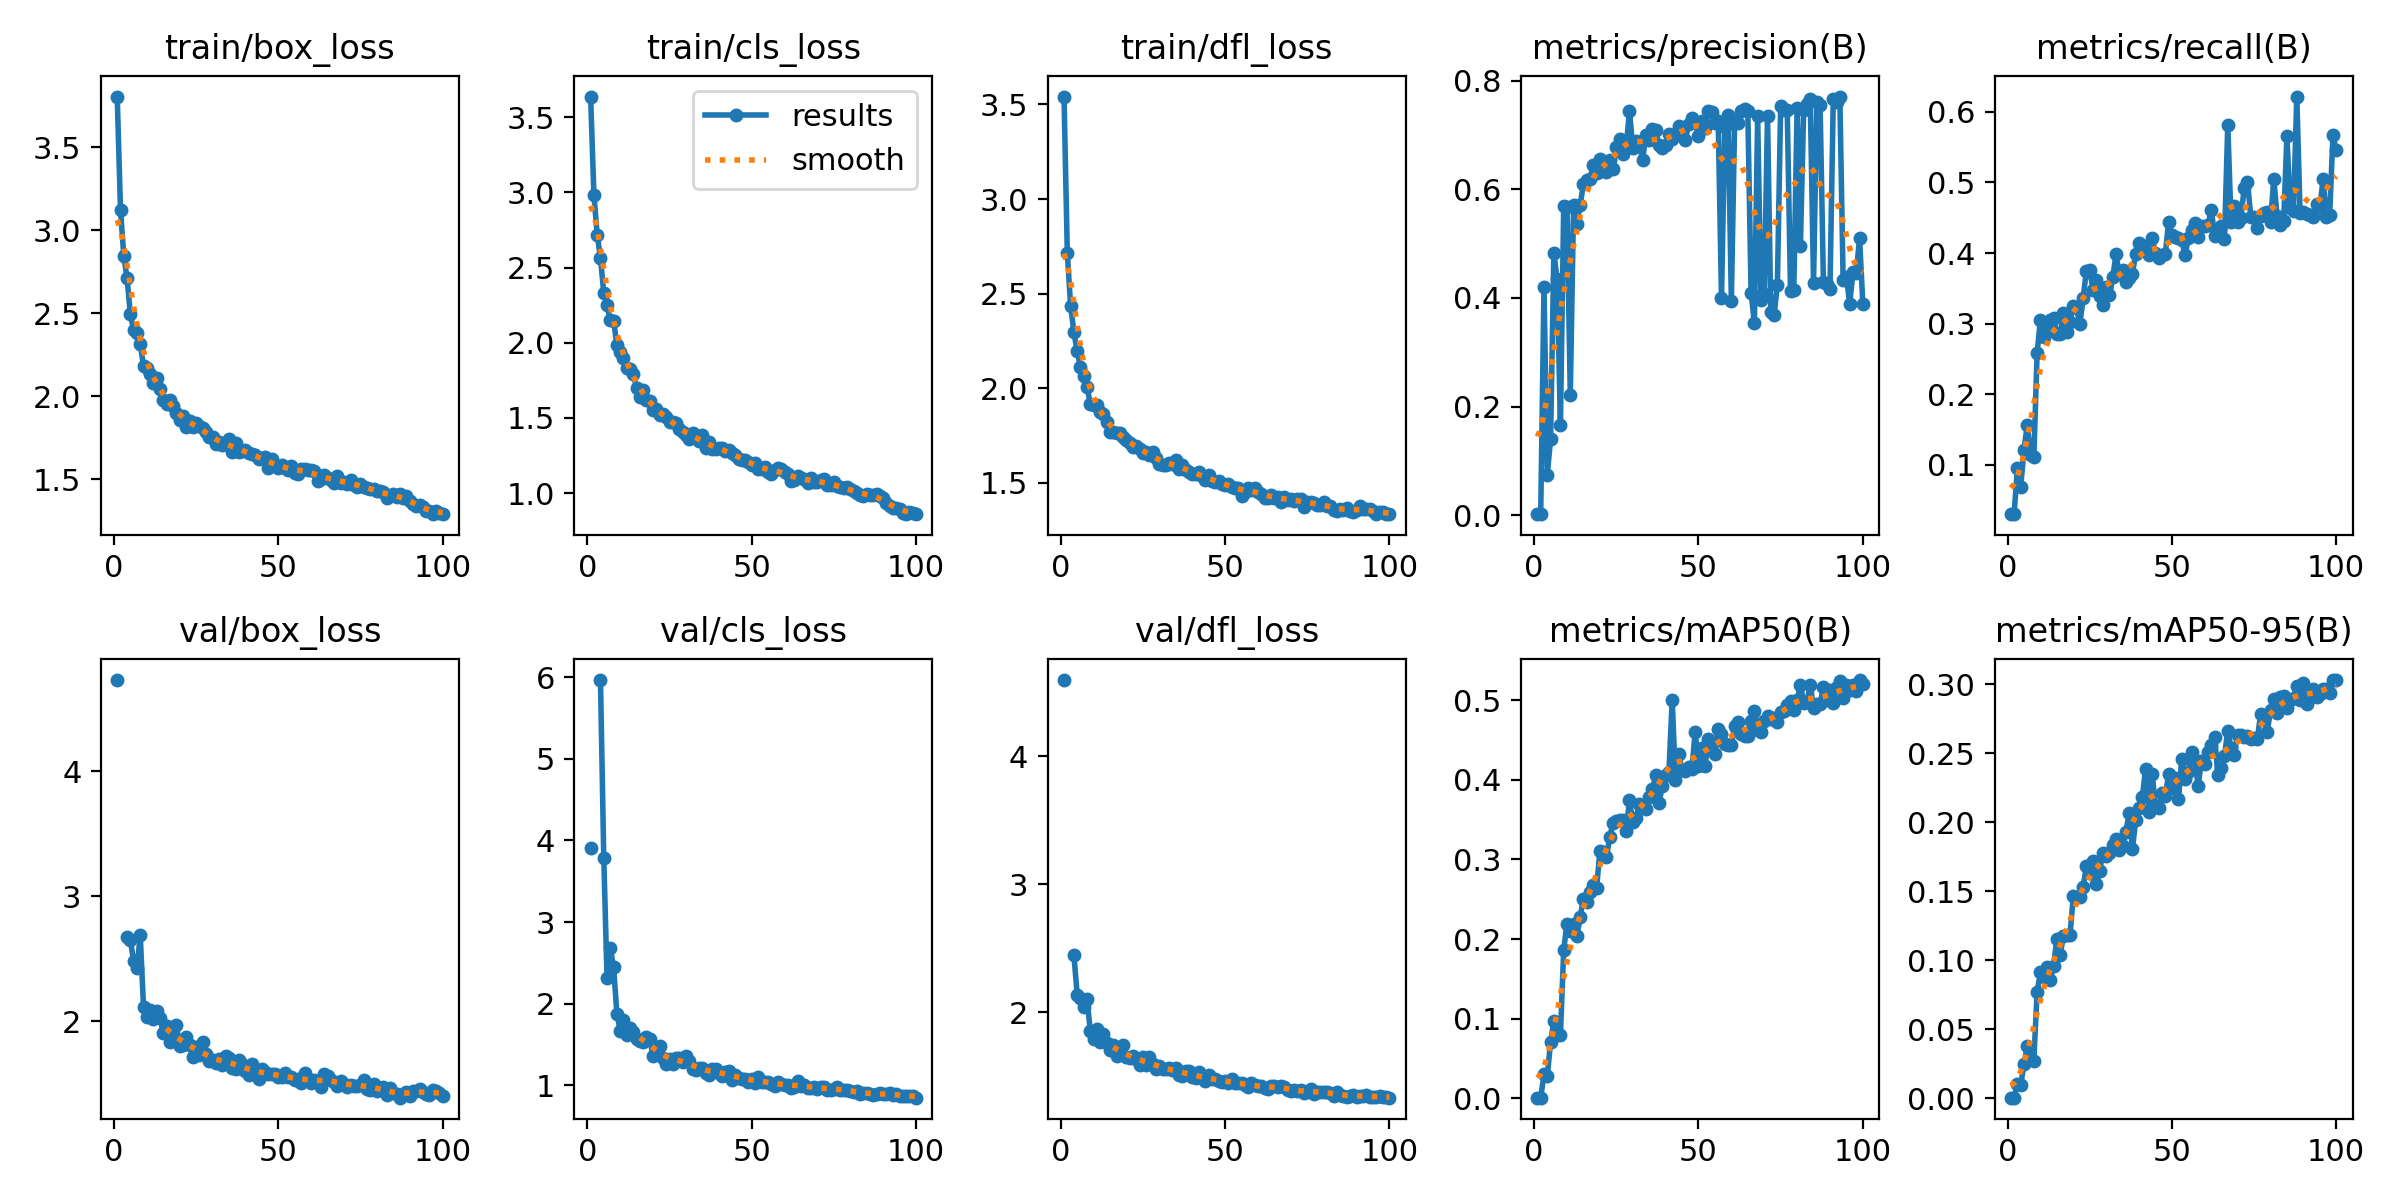

In [18]:
from IPython.display import Image

Image(filename='/content/drive/MyDrive/YOLOv12m_optimized_training6/results.png', width=1000)

In [19]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Attentive', 'Distracted', 'Teacher']

In [21]:
from supervision.metrics import MeanAveragePrecision

model = YOLO('/content/drive/MyDrive/YOLOv12m_optimized_training6/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [22]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.288491850636813
mAP 50 0.6064260562393647
mAP 75 0.30006149617917366


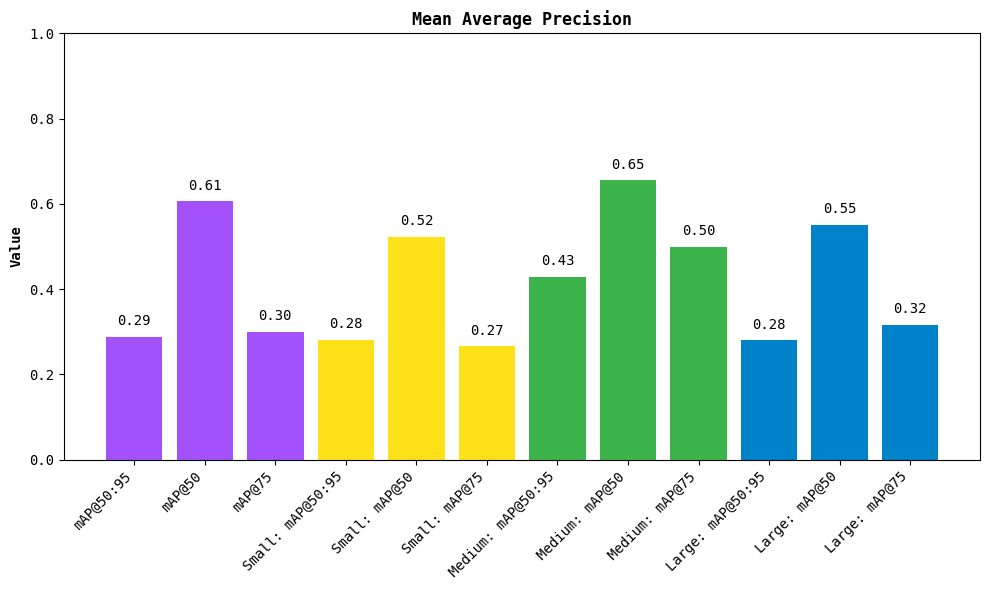

In [23]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [24]:
import supervision as sv


ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

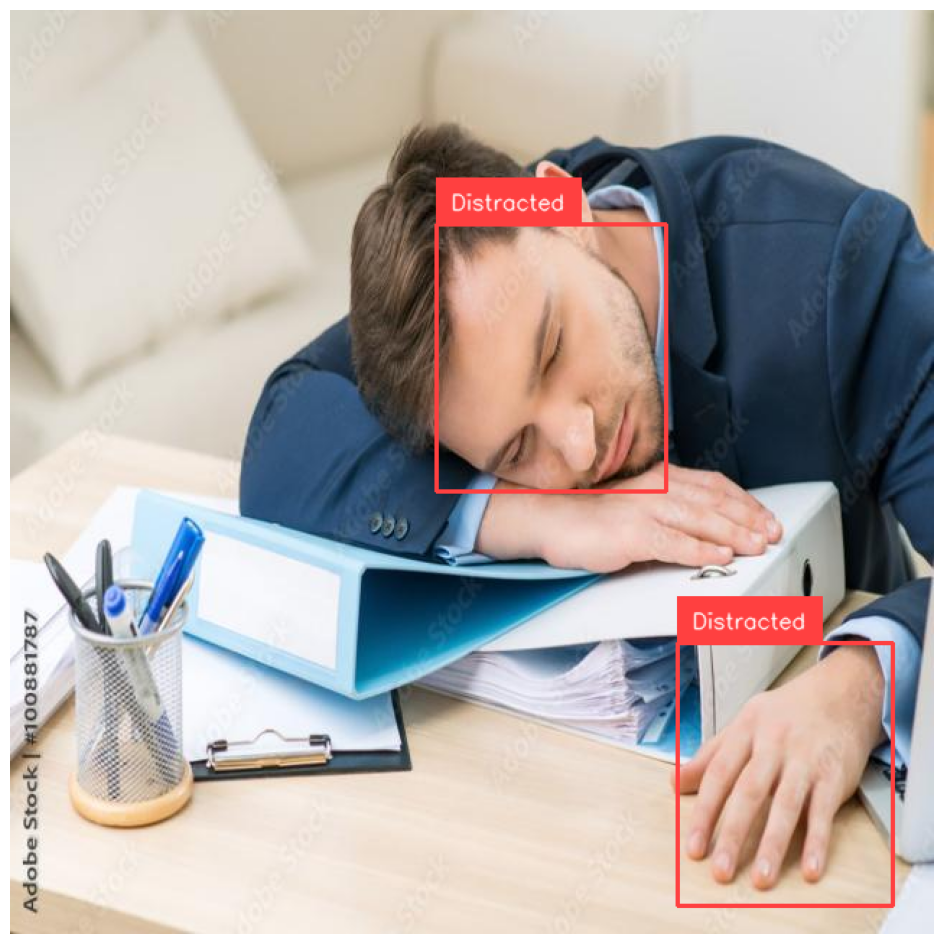

In [30]:
import random

i = random.randint(129, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)